In [2]:
import ReferentialGym

import torch
import torchvision
import torchvision.transforms as T 

# Hyperparameters:

In [1]:
rg_config = {
    "observability":            "full",
    "max_sentence_length":      10,
    "nbr_communication_round":  1,
    "nbr_distractors":          127,
    "distractor_sampling":      "uniform",
    "descriptive":              False,
    "object_centric":           False,
    "nbr_stimulus":             1,

    "graphtype":                'straight_through_gumbel_softmax', #'reinforce'/'gumbel_softmax'/'straight_through_gumbel_softmax' 
    "tau":                      0.2,
    "vocab_size":               20,

    "cultural_pressure_it_period": 100,
    "cultural_substrate_size":  5,
    
    "batch_size":               128,
    "dataloader_num_worker":    8,
    
    "learning_rate":            1e-3,
    "adam_eps":                 1e-5,
    "gradient_clip":            5,

    "use_cuda":                 True,
}

# Agent Configuration:

In [4]:
speaker_config = dict()
speaker_config['nbr_distractors'] = 0 if rg_config['observability'] == "partial" else rg_config['nbr_distractors']
speaker_config['nbr_stimulus'] = rg_config['nbr_stimulus']

# Assuming CNN task:
#speaker_config['observation_resize_dim'] = 64
# Assuming FC task:
#speaker_config['preprocess_function'] = 'PreprocessFunction'

# Recurrent Convolutional Architecture:
speaker_config['cnn_encoder_channels'] = [32, 32, 64]
speaker_config['cnn_encoder_kernels'] = [6, 4, 3]
speaker_config['cnn_encoder_strides'] = [6, 2, 1]
speaker_config['cnn_encoder_paddings'] = [0, 1, 1]
speaker_config['cnn_encoder_feature_dim'] = 512
speaker_config['cnn_encoder_mini_batch_size'] = 128
speaker_config['temporal_encoder_nbr_hidden_units'] = 512
speaker_config['temporal_encoder_nbr_rnn_layers'] = 1
speaker_config['temporal_encoder_mini_batch_size'] = 128
speaker_config['symbol_processing_nbr_hidden_units'] = 512
speaker_config['symbol_processing_nbr_rnn_layers'] = 2

import copy
listener_config = copy.deepcopy(speaker_config)
listener_config['nbr_distractors'] = rg_config['nbr_distractors']

# Basic Agents

## Basic Speaker:

In [5]:
from ReferentialGym.agents import BasicCNNSpeaker

In [6]:
batch_size = 4
nbr_distractors = speaker_config['nbr_distractors']
nbr_stimulus = speaker_config['nbr_stimulus']
obs_shape = [nbr_distractors+1,nbr_stimulus,1,28,28]
feature_dim = 512
vocab_size = rg_config['vocab_size']
max_sentence_length = rg_config['max_sentence_length']

bspeaker = BasicCNNSpeaker(kwargs=speaker_config, 
                              obs_shape=obs_shape, 
                              feature_dim=feature_dim, 
                              vocab_size=vocab_size, 
                              max_sentence_length=max_sentence_length)

In [7]:
'''
stimuli = torch.zeros((batch_size,nbr_distractors+1,nbr_stimulus,1,28,28))
st_size = stimuli.size()
print(st_size)
y_logits, y_one_hot = bspeaker(stimuli, multi_round=True)
print(y_logits.size())

next_y_logits, next_y_one_hot = bspeaker(stimuli, 
                                         sentences=y_one_hot, 
                                         graphtype='straight_through_gumbel_softmax', 
                                         multi_round=True)
print(next_y_logits.size())
'''

"\nstimuli = torch.zeros((batch_size,nbr_distractors+1,nbr_stimulus,1,28,28))\nst_size = stimuli.size()\nprint(st_size)\ny_logits, y_one_hot = bspeaker(stimuli, multi_round=True)\nprint(y_logits.size())\n\nnext_y_logits, next_y_one_hot = bspeaker(stimuli, \n                                         sentences=y_one_hot, \n                                         graphtype='straight_through_gumbel_softmax', \n                                         multi_round=True)\nprint(next_y_logits.size())\n"

## Basic Listener:

In [8]:
from ReferentialGym.agents import BasicCNNListener

In [9]:
batch_size = 4
nbr_distractors = listener_config['nbr_distractors']
nbr_stimulus = listener_config['nbr_stimulus']
obs_shape = [nbr_distractors+1,nbr_stimulus,1,28,28]
feature_dim = 512
vocab_size = rg_config['vocab_size']
max_sentence_length = rg_config['max_sentence_length']

blistener = BasicCNNListener(kwargs=listener_config, 
                              obs_shape=obs_shape, 
                              feature_dim=feature_dim, 
                              vocab_size=vocab_size, 
                              max_sentence_length=max_sentence_length)

In [10]:
'''
stimuli = torch.zeros((batch_size,nbr_distractors+1,nbr_stimulus,1,28,28))
st_size = stimuli.size()
print(st_size)
#y_logits, y_one_hot = bspeaker(stimuli)
print(y_logits.size())
decision_logits, next_sentences_logits, next_sentences = blistener(sentences=y_logits, 
                                                                   stimuli=stimuli, 
                                                                   graphtype='straight_through_gumbel_softmax',
                                                                   multi_round=True)
print(decision_logits)
print(next_sentences.size())
'''

"\nstimuli = torch.zeros((batch_size,nbr_distractors+1,nbr_stimulus,1,28,28))\nst_size = stimuli.size()\nprint(st_size)\n#y_logits, y_one_hot = bspeaker(stimuli)\nprint(y_logits.size())\ndecision_logits, next_sentences_logits, next_sentences = blistener(sentences=y_logits, \n                                                                   stimuli=stimuli, \n                                                                   graphtype='straight_through_gumbel_softmax',\n                                                                   multi_round=True)\nprint(decision_logits)\nprint(next_sentences.size())\n"

# MNIST Dataset:

In [11]:
#dataset = torchvision.datasets.MNIST(root='./datasets/', train=True, transform=None, target_transform=None, download=True)
dataset = torchvision.datasets.MNIST(root='./datasets/', train=True, transform=T.ToTensor(), target_transform=None, download=False)

In [12]:
%matplotlib inline
#notebook
import matplotlib.pyplot as plt
#plt.imshow(dataset[0][0])
#plt.show()

In [13]:
from ReferentialGym.datasets import LabeledDataset

In [14]:
dataset_args = {
    "dataset_class":            "LabeledDataset",
    "dataset":                  dataset,
    "nbr_stimulus":             rg_config['nbr_stimulus'],
    "nbr_distractors":          rg_config['nbr_distractors'],
}

dataset_mnistrg = LabeledDataset(kwargs=dataset_args)

In [15]:
st = dataset_mnistrg[0]

In [16]:
st.size()


torch.Size([128, 1, 1, 28, 28])

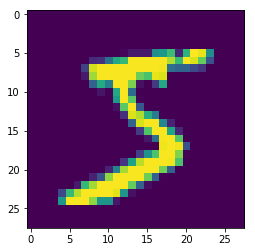

In [17]:
plt.imshow(T.ToPILImage()(st[0,0]))

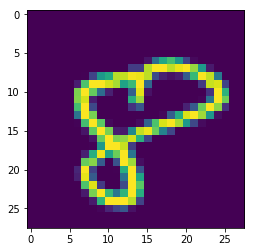

In [18]:
plt.imshow(T.ToPILImage()(st[1,0]))

In [19]:
import math
size = 2
distractors = 2
result = [0 for _ in range(distractors+1)]
for idx in range( int(math.pow(size,distractors+1))):
    indices = [0 for _ in range(distractors+1)]
    idx2reduce = idx
    for item_idx in reversed(range(distractors+1)):
        exponant = item_idx
        outof = int(math.pow(size, exponant)) 
        if outof > idx2reduce: continue
        remainder = (idx2reduce//outof) % size 
        indices[item_idx] = remainder
        idx2reduce -= size
    print(idx,'\t', indices)
    result = [ r+i for i,r in zip(indices, result)]
print(result)


0 	 [0, 0, 0]
1 	 [1, 0, 0]
2 	 [0, 1, 0]
3 	 [1, 1, 0]
4 	 [0, 1, 1]
5 	 [1, 1, 1]
6 	 [0, 0, 1]
7 	 [1, 0, 1]
[4, 4, 4]


# Referential Game:

In [20]:
dataset_args = {
    "dataset_class":            "LabeledDataset",
    "dataset":                  dataset,
    "nbr_stimulus":             rg_config['nbr_stimulus'],
    "nbr_distractors":          rg_config['nbr_distractors'],
}

print(dataset_args)
refgame = ReferentialGym.make(config=rg_config, dataset_args=dataset_args)

{'dataset_class': 'LabeledDataset', 'dataset': Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./datasets/
    Transforms (if any): ToTensor()
    Target Transforms (if any): None, 'nbr_stimulus': 1, 'nbr_distractors': 127}


In [21]:
from tensorboardX import SummaryWriter
logger = SummaryWriter('./example_log')

In [22]:
nbr_epoch = 100

In [23]:
refgame.train(prototype_speaker=bspeaker, 
              prototype_listener=blistener, 
              nbr_epoch=nbr_epoch,
              logger=logger,
              verbose_period=100)

RuntimeError: CUDA out of memory. Tried to allocate 538.00 MiB (GPU 0; 5.93 GiB total capacity; 1.75 GiB already allocated; 57.75 MiB free; 41.80 MiB cached)